https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [1]:
import pandas as pd
import numpy as np
df_update = pd.read_csv('df_skill_div.csv', index_col=[0])
skill_cell = pd.read_csv('skill_cell.csv',header=None)

In [2]:
skill_cell

,0
0,"Python, SQL, R, Spark, Hive, AWS, Data Warehou..."
1,"SQL, R, Excel, Network"
2,"R, Excel"
3,"R, Microsoft Office, Excel, Marketing"
4,R
5,R
6,"Python, SQL, R, Java, Tableau, AWS, Data Analy..."
7,"R, Excel"
8,"R, Microsoft Office, Excel, Go"
9,R


In [3]:
skill_cell.columns=['skill_list']
skill_cell.head()

,skill_list
0,"Python, SQL, R, Spark, Hive, AWS, Data Warehou..."
1,"SQL, R, Excel, Network"
2,"R, Excel"
3,"R, Microsoft Office, Excel, Marketing"
4,R


In [4]:
list_of_skill = skill_cell['skill_list'].to_list()

In [5]:
#data_ready可以直接用list of list skill
#保留desc
#Business Analyst, Business Analyst

In [10]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend([','])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [11]:
df = df_update

In [12]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = list_of_skill
data_words = list(sent_to_words(data))
print(data_words[:20])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['python', 'sql', 'spark', 'hive', 'aws', 'data', 'warehouse', 'business', 'intelligence', 'network'], ['sql', 'excel', 'network'], ['excel'], ['microsoft', 'office', 'excel', 'marketing'], [], [], ['python', 'sql', 'java', 'tableau', 'aws', 'data', 'analysis', 'postgresql', 'mysql', 'saas', 'ssh', 'tomcat'], ['excel'], ['microsoft', 'office', 'excel', 'go'], [], ['sql', 'marketing', 'css', 'wordpress'], ['software', 'development', 'net', 'sharepoint'], ['python', 'sql', 'tableau', 'linux', 'go', 'css', 'gis', 'google', 'analytics', 'omniture', 'workday'], [], ['sql'], ['python', 'excel'], ['sql', 'sas', 'matlab', 'data', 'science', 'go'], ['sql', 'excel'], ['python', 'sql', 'spark', 'sdlc'], ['sql', 'microsoft', 'office', 'excel', 'project', 'management', 'accounting']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.324*"management" + 0.115*"power" + 0.091*"accounting" + '
  '0.045*"sharepoint" + 0.044*"account" + 0.037*"peoplesoft" + '
  '0.020*"regulatory" + 0.020*"reporting" + 0.020*"process" + '
  '0.018*"hyperion"'),
 (1,
  '0.232*"business" + 0.171*"intelligence" + 0.129*"datum" + 0.107*"analysis" '
  '+ 0.034*"network" + 0.032*"science" + 0.026*"ai" + 0.025*"warehouse" + '
  '0.025*"big" + 0.024*"project"'),
 (2,
  '0.308*"marketing" + 0.078*"analytic" + 0.045*"omniture" + '
  '0.031*"confluence" + 0.031*"jira" + 0.030*"digital" + 0.029*"visual" + '
  '0.028*"saa" + 0.026*"workday" + 0.026*"sdlc"'),
 (3,
  '0.343*"go" + 0.238*"office" + 0.214*"excel" + 0.031*"seo" + 0.022*"ach" + '
  '0.020*"platform" + 0.012*"sps" + 0.006*"program" + 0.006*"android" + '
  '0.004*"performance"')]


In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8750,"business, intelligence, datum, analysis, netwo...","[datum, warehouse, business, intelligence, net..."
1,1,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
2,2,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
3,3,3.0,0.6250,"go, office, excel, seo, ach, platform, sps, pr...",[office]
4,4,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
5,5,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
6,6,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
7,7,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]
8,8,3.0,0.8125,"go, office, excel, seo, ach, platform, sps, pr...","[office, excel, go]"
9,9,0.0,0.2500,"management, power, accounting, sharepoint, acc...",[]


In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8750,"management, power, accounting, sharepoint, account, peoplesoft, regulatory, reporting, process, ...","[audits, manage, care, regulatory, reporting]"
1,1.0,0.8750,"business, intelligence, datum, analysis, network, science, ai, warehouse, big, project","[datum, warehouse, business, intelligence, network]"
2,2.0,0.8499,"marketing, analytic, omniture, confluence, jira, digital, visual, saa, workday, sdlc","[visual, basic, operation, research]"
3,3.0,0.8500,"go, office, excel, seo, ach, platform, sps, program, android, performance","[office, excel, go, ach]"


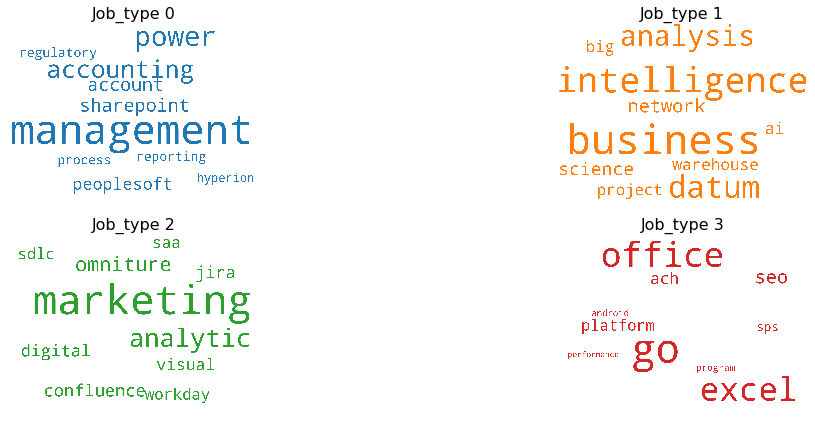

In [17]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Job_type ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

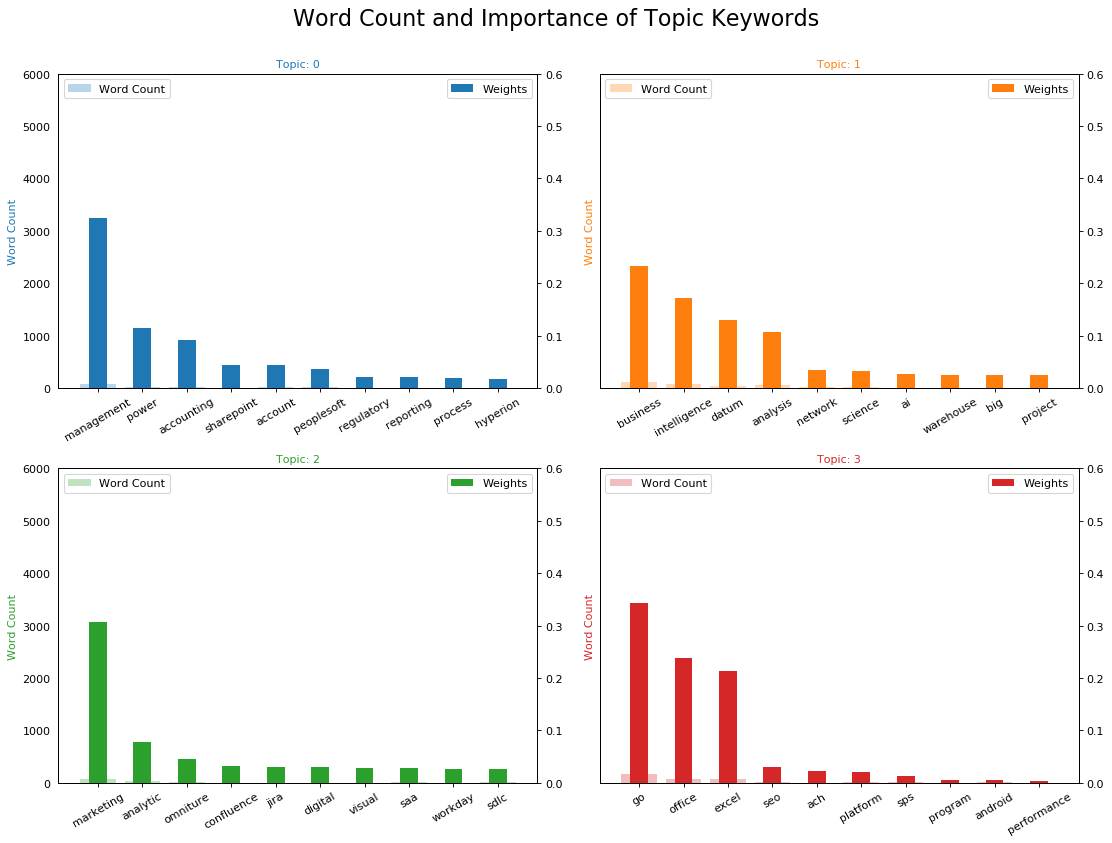

In [18]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.8, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.4, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.6); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)    
plt.show()

In [19]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

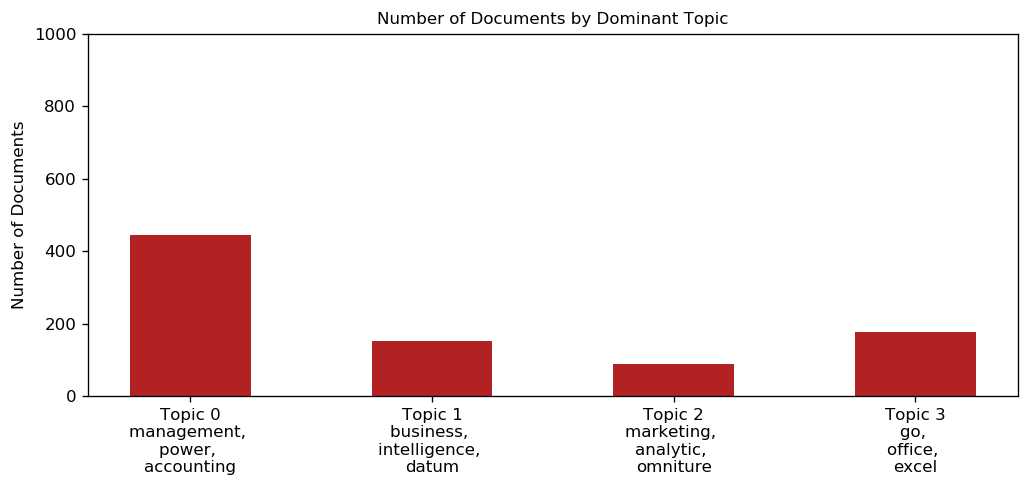

In [20]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

plt.show()

In [21]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=1200, plot_height=600)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 507 samples in 0.000s...
[t-SNE] Computed neighbors for 507 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 507 / 507
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.755150
[t-SNE] KL divergence after 1000 iterations: 0.103776


Loading BokehJS ...

In [22]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.324182  0.171019       1        1  31.907230
3     -0.275655  0.219837       2        1  25.735533
0      0.004789 -0.269878       3        1  21.831898
2     -0.053317 -0.120978       4        1  20.525343, topic_info=    Category        Freq          Term       Total  loglift  logprob
7    Default  120.000000            go  120.000000  30.0000  30.0000
17   Default   97.000000    management   97.000000  29.0000  29.0000
9    Default   86.000000     marketing   86.000000  28.0000  28.0000
0    Default  101.000000      business  101.000000  27.0000  27.0000
5    Default   84.000000        office   84.000000  26.0000  26.0000
6    Default   75.000000         excel   75.000000  25.0000  25.0000
2    Default   75.000000  intelligence   75.000000  24.0000  24.0000
1    Default   56.000000         datum   56.000000  23.0000  23.0000
48   Default   34.000000         power   34.000000  22.0000  22.0000
38   Default   47.000000      analysis   47.000000  21.0000  21.0000
16   Default   27.000000    accounting   27.000000  20.0000  20.0000
12   Default   22.000000      analytic   22.000000  19.0000  19.0000
13   Default   13.000000      omniture   13.000000  18.0000  18.0000
10   Default   14.000000    sharepoint   14.000000  17.0000  17.0000
21   Default   13.000000       account   13.000000  16.0000  16.0000
44   Default   11.000000    peoplesoft   11.000000  15.0000  15.0000
3    Default   15.000000       network   15.000000  14.0000  14.0000
31   Default   14.000000       science   14.000000  13.0000  13.0000
100  Default    9.000000    confluence    9.000000  12.0000  12.0000
128  Default    9.000000          jira    9.000000  11.0000  11.0000
43   Default   11.000000           seo   11.000000  10.0000  10.0000
33   Default    9.000000       digital    9.000000   9.0000   9.0000
83   Default    8.000000        visual    8.000000   8.0000   8.0000
23   Default    8.000000           saa    8.000000   7.0000   7.0000
15   Default    7.000000          sdlc    7.000000   6.0000   6.0000
52   Default   12.000000            ai   12.000000   5.0000   5.0000
14   Default    7.000000       workday    7.000000   4.0000   4.0000
50   Default    7.000000            id    7.000000   3.0000   3.0000
11   Default    7.000000      software    7.000000   2.0000   2.0000
4    Default   11.000000     warehouse   11.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
12    Topic4   21.801874      analytic   22.362343   1.5581  -2.5512
13    Topic4   12.625981      omniture   13.202363   1.5389  -3.0974
128   Topic4    8.693196          jira    9.271999   1.5191  -3.4707
33    Topic4    8.509809       digital    9.086622   1.5179  -3.4920
100   Topic4    8.802284    confluence    9.401702   1.5176  -3.4582
83    Topic4    8.065384        visual    8.648301   1.5137  -3.5456
23    Topic4    7.734556           saa    8.320051   1.5105  -3.5875
15    Topic4    7.260420          sdlc    7.837320   1.5071  -3.6508
50    Topic4    7.037647            id    7.607049   1.5057  -3.6819
14    Topic4    7.280828       workday    7.971540   1.4929  -3.6480
11    Topic4    6.950971      software    7.640456   1.4889  -3.6943
19    Topic4    6.144196     operation    6.775587   1.4857  -3.8177
133   Topic4    5.094336          chef    5.696680   1.4718  -4.0051
134   Topic4    5.094336     kubernete    5.696680   1.4718  -4.0051
135   Topic4    5.094336           svn    5.696680   1.4718  -4.0051
34    Topic4    6.098583        market    6.951389   1.4526  -3.8251
49    Topic4    2.404622      clinical    2.960601   1.3755  -4.7558
51    Topic4    2.360652         trial    2.916837   1.3719  -4.7743
90    Topic4    2.222664        report    2.785771   1.3577  -4.8345
127   Topic4    1.674774   development    2.284442   1.2731  -5.1175
136   Topic4    4.841219   performance    6.6

In [23]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
pyLDAvis.save_html(p, 'lda.html')

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
